# Decision Tree for Regression

In [1]:
# import the necessary libraries we need for the analysis
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error

RSEED =  42

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Within the *models* folder we can't see the *data* folder as they are siblings to the parent folder *nf-flight-delay*. Therefore, we need to address the path to the dataset manually.

In [2]:
# get the absolute path to the parent directory 'nf-flight-delay'
d = os.path.dirname(os.getcwd())

In [3]:
# create absolute path to the dataset
path = d + '/data/Train_cleaned.csv'

In [4]:
df = pd.read_csv(path, sep=";")
df

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,AC,target,hour_STA,hour_STD,...,season_num,outcome,country_arr,elevation_arr,lat_arr,lon_arr,country_dep,elevation_dep,lat_dep,lon_dep
0,2016-01-03 00:00:00,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,TU 32AIMN,260.0,12,10,...,3,1,TN,22,36.851002,10.22720,MA,656,33.367500,-7.58997
1,2016-01-13 00:00:00,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,TU 31BIMO,20.0,16,15,...,3,1,TN,22,36.851002,10.22720,IT,768,45.630600,8.72811
2,2016-01-16 00:00:00,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,TU 32AIMN,0.0,6,4,...,3,0,TR,325,41.275333,28.75200,TN,22,36.851002,10.22720
3,2016-01-17 00:00:00,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,TU 736IOK,0.0,17,14,...,3,0,FR,90,47.153198,-1.61073,TN,19,33.875000,10.77550
4,2016-01-17 00:00:00,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,TU 320IMU,22.0,15,14,...,3,1,DZ,82,36.691002,3.21541,TN,22,36.851002,10.22720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107167,2018-07-05 00:00:00,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,TU 32AIML,0.0,2,23,...,1,0,TN,22,36.851002,10.22720,TN,22,36.851002,10.22720
107168,2018-01-13 00:00:00,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,UG AT7AT7,0.0,9,8,...,3,0,TN,22,36.851002,10.22720,TN,19,33.875000,10.77550
107169,2018-11-07 00:00:00,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,TU 736IOK,0.0,12,5,...,2,0,TN,22,36.851002,10.22720,TN,22,36.851002,10.22720
107170,2018-01-23 00:00:00,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,TU CR9ISA,0.0,18,18,...,3,0,TN,19,33.875000,10.77550,TN,22,36.851002,10.22720


## Setup data

#### Feature Encoding

To use the countries as input features, we need to convert their abbreviations to numbers, i.e. performing label encoding.

In [5]:
# 1) encode departure countries
le1 = LabelEncoder()
le1.fit(df['country_dep'])
df['country_dep'] = le1.transform(df['country_dep'])

# 2) encode arrival countries
le2 = LabelEncoder()
le2.fit(df['country_arr'])
df['country_arr'] = le2.transform(df['country_arr'])

# 2) encode flight id
le3 = LabelEncoder()
le3.fit(df['FLTID'])
df['FLTID'] = le3.transform(df['FLTID'])

#### Estimate Feature Correlation

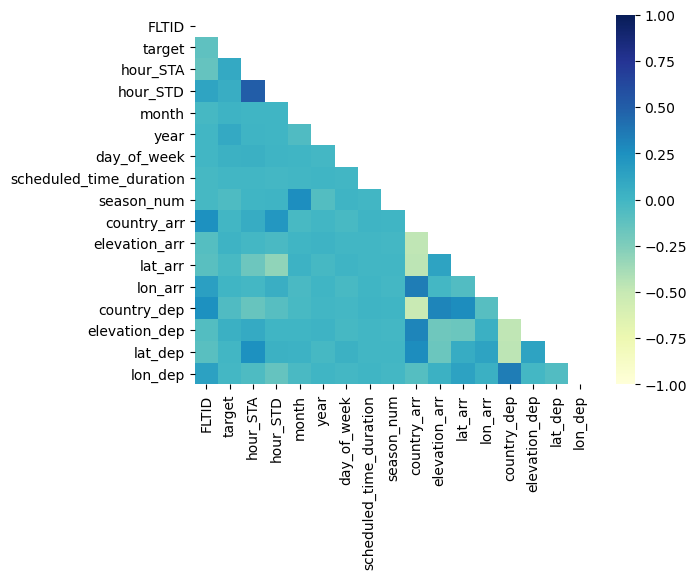

In [6]:
# Calculate correlation heatmap
correlations = df.drop(['outcome'], axis=1).corr()
mask = np.triu(correlations)
sns.heatmap(correlations, vmax=1, vmin=-1, annot=False, mask=mask, cmap="YlGnBu");

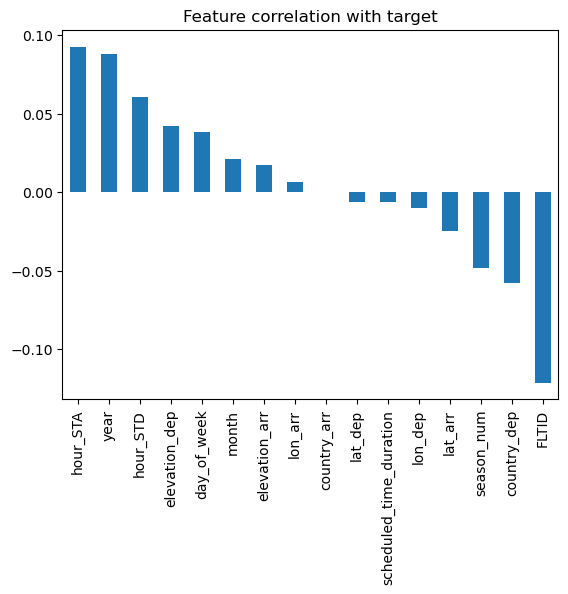

In [7]:
# Show only correlation with the target
t_corr = correlations['target']
t_corr.sort_values(ascending=False)[1:].plot(kind='bar', title='Feature correlation with target');

Overall the features show only weak correlation with the target. Despite, the features having most influence are:
- FLTID (-0.121)
- hour_STA (+0.093)
- year (+0.088)
- hour_STD (+0.060)
- country_dep (-0.058)
- season (-0.048)
- elevation_dep (+0.042)
- day_of_week (0.039)

#### Spliting data

In [8]:
# Define features and target
y = df['target']
X = df[['FLTID','hour_STA','hour_STD','country_dep','season_num','elevation_dep','day_of_week']]

# Split the features and target data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED, train_size = .8)

## Trainining the model

In [9]:
# What parameters does Decision Tree Regressor have?
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [10]:
# Initializing regressor
dec_tree = DecisionTreeRegressor(random_state=RSEED)

In [11]:
# fit the regressor with X_train and y_train data 
dec_tree.fit(X_train, y_train) 

DecisionTreeRegressor(random_state=42)

In [12]:
# Make prediction 
y_pred_train = dec_tree.predict(X_train)
y_pred_test = dec_tree.predict(X_test)

# Calculate r-squared 
print("R-squared (train):", r2_score(y_train, y_pred_train).round(3))
print("R-squared (test):", r2_score(y_test, y_pred_test).round(3))

# Calculate RMSE
print("RMSE (train): ", mean_squared_error(y_train, y_pred_train, squared=False).round(3))
print("RMSE (test): ", mean_squared_error(y_test, y_pred_test, squared=False).round(3))

R-squared (train): 0.388
R-squared (test): -0.159
RMSE (train):  91.744
RMSE (test):  122.339


#### GridSearch

In [13]:
# Defining parameter grid (as dictionary)
param_grid = {"max_leaf_nodes": list(range(5,13)),
              "max_depth" : list(range(2,15)),
              "min_samples_split" : [2, 5, 10, 15, 20, 30, 40, 60, 100],
              "min_samples_leaf" : [5, 10, 15, 20, 25, 30, 50, 75, 100],
              "criterion": ['squared_error']
             }

# Instantiate gridsearch and define the metric to optimize 
grid_tree = GridSearchCV(DecisionTreeRegressor(random_state=RSEED), param_grid, scoring='neg_root_mean_squared_error',
                  cv=5, verbose=1, n_jobs=-1)

# Fit gridsearch object to data
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 8424 candidates, totalling 42120 fits


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14],
                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [5, 10, 15, 20, 25, 30, 50, 75,
                                              100],
                         'min_samples_split': [2, 5, 10, 15, 20, 30, 40, 60,
                                               100]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [14]:
# Best rmse
print('Best RMSE:', -1*round(grid_tree.best_score_, 3))

# Best parameters
print('Best parameters:', grid_tree.best_params_)

Best RMSE: 114.117
Best parameters: {'criterion': 'squared_error', 'max_depth': 6, 'max_leaf_nodes': 12, 'min_samples_leaf': 25, 'min_samples_split': 2}


In [15]:
# Assigning the fitted Tree-Regressor model with best parameter combination to a new variable tree_best
tree_best = grid_tree.best_estimator_

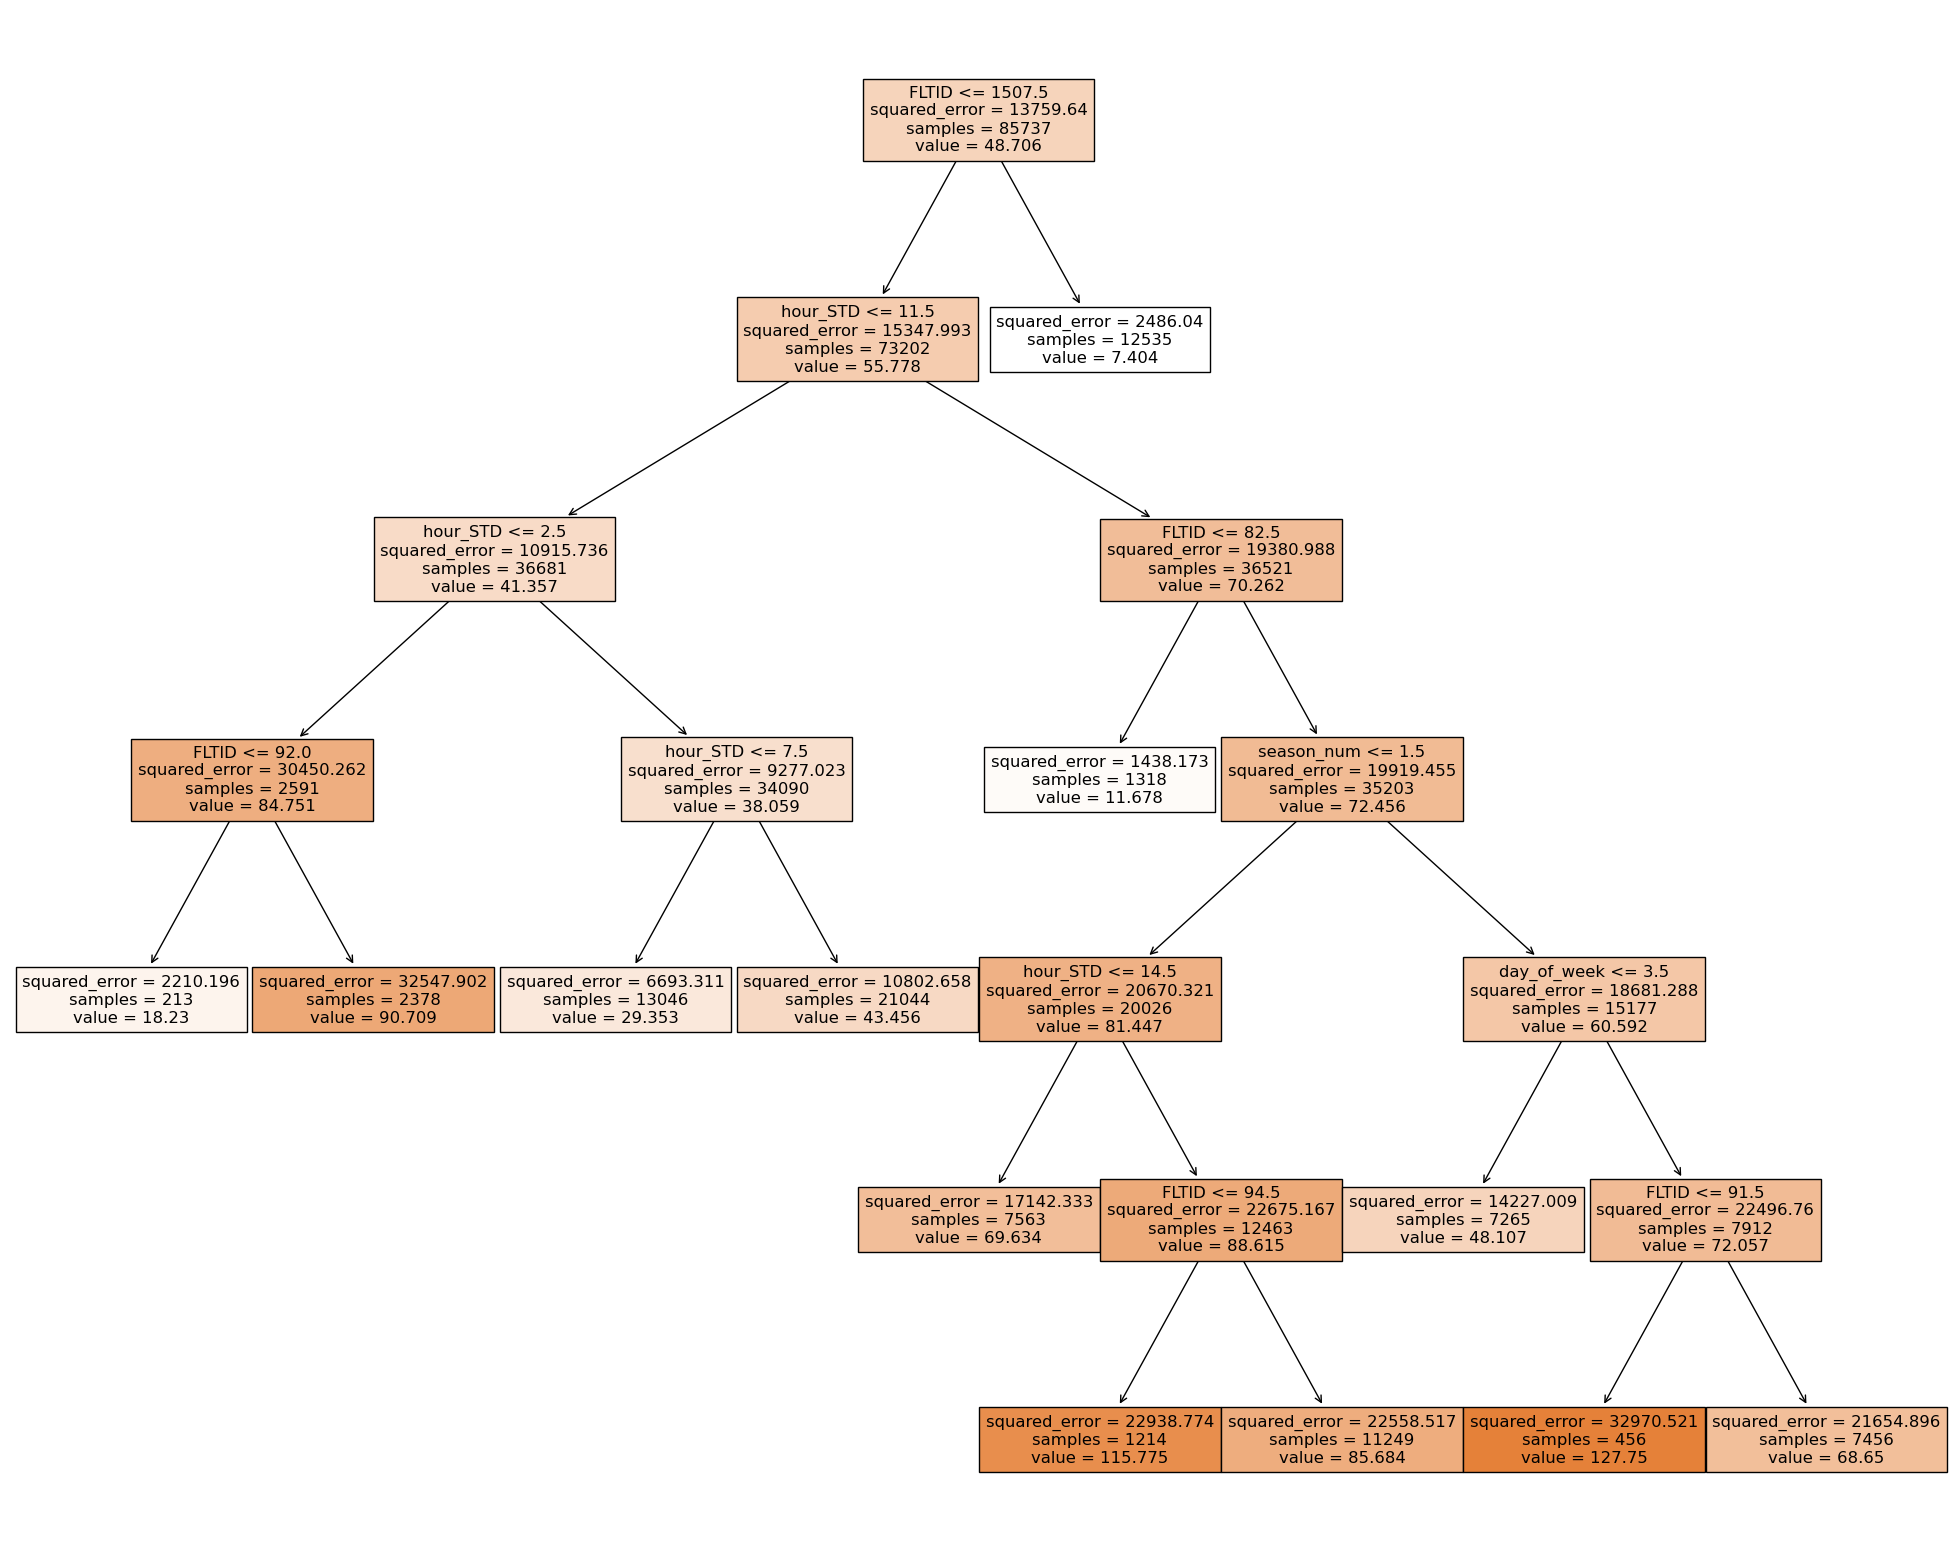

In [16]:
# Plot best tree model
fig = plt.figure(figsize=(25,20))
dectree_plot = plot_tree(tree_best, feature_names=X_train.columns.tolist(), filled=True)

In [17]:
# Make prediction 
y_pred_train_best = tree_best.predict(X_train)
y_pred_test_best = tree_best.predict(X_test)

# Calculate r-squared 
print("R-squared (train):", r2_score(y_train, y_pred_train_best).round(3))
print("R-squared (test):", r2_score(y_test, y_pred_test_best).round(3))

# Calculate RMSE
print("RMSE (train): ", mean_squared_error(y_train, y_pred_train_best, squared=False).round(3))
print("RMSE (test): ", mean_squared_error(y_test, y_pred_test_best, squared=False).round(3))

R-squared (train): 0.053
R-squared (test): 0.052
RMSE (train):  114.125
RMSE (test):  110.675
